# Test MFTI training

In [ ]:
#!pip install segmentation_models_pytorch
#!pip install torchmetrics

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from pathlib import Path
from typing import Any, Callable, Optional
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import random
import sys
import os
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
import time
from torchmetrics.segmentation import MeanIoU
from torch import randint

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cpu


In [3]:
USE_GOOGLE_DRIVE = False
if USE_GOOGLE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')

In [4]:
if USE_GOOGLE_DRIVE:
    py_file_location = "/content/drive/MyDrive/AI"
    sys.path.append(os.path.abspath(py_file_location))
    root_dataset = str(os.path.join(py_file_location, "Pascal-part"))
    BASE_OUTPUT = "/content/drive/MyDrive/AI/MFTI/output"
    print("py_file_location=",py_file_location)
else:
    BASE_OUTPUT = "output"
    root_dataset = "Pascal-part"

In [5]:
class PascalDataset(Dataset):
    def __init__(self, basic_path='',subset='train',n_limit=None,transforms=None, transforms_mask=None):
        if subset == None or subset not in ["train", "val"]:
            raise (ValueError(
                f"{subset} is not a valid input. Acceptable values are \"train\" and \"val\"."
            ))
        self.n_limit = n_limit
        self.transforms = transforms; self.transforms_mask = transforms_mask
        self.basic_path = basic_path
        self.imgs_path = Path(basic_path) / 'JPEGImages'
        self.msks_path = Path(basic_path) / 'gt_masks'
        file_name = 'train_id.txt' if subset == 'train' else 'val_id.txt'
        files_list_path = Path(basic_path) / file_name
        if not files_list_path.exists():
            raise OSError(f"{files_list_path} does not exist.")
        # else:
        #     print(f"files list path is ",files_list_path)

        with open(files_list_path) as f:
            #self.ids = f.readlines()
            self.ids = [line.rstrip('\n') for line in f]
        if n_limit is not None:
            n_limit = min(n_limit,len(self.ids))
            self.ids = self.ids[:n_limit]
            print("Dataset length is limited with",n_limit)
        #print(f"ids is {type(self.ids)}",len(self.ids))
        #print(self.ids[:20])

    def __len__(self) -> int:
        return len(self.ids)

    def __getitem__(self, index: int) -> Any:
        idd = self.ids[index]
        file_name = idd+'.jpg'
        img_path = self.imgs_path / file_name
        if not img_path.exists():
            raise OSError(f"Img path {img_path} does not exist.")
        # else:
        #     print(f"Img path is ",img_path)

        file_name = idd+'.npy'
        msk_path = self.msks_path / file_name
        if not msk_path.exists():
            raise OSError(f"Msk path {msk_path} does not exist.")
        # else:
        #     print(f"Msk path is ",msk_path)

        image = np.asarray(Image.open(img_path))
        mask = np.load(msk_path)

        if image.shape[:2] != mask.shape:
            raise OSError(f"image.shape {image.shape} is not match to mask {mask.shape}")

        #! for not normalize mask in [0. .. 1.] but left in [0 .. 6]
        mask = mask.astype(np.int64)

        if self.transforms:
            image = self.transforms(image.copy()) #.copy() to make writable
        if self.transforms_mask:
            mask = self.transforms_mask(mask.copy())
        #mask = mask.to(torch.float) # ?

        #mask = mask.squeeze(0) # remote one extra dimention

        #print("img is",type(image), " msk is",type(mask), image.shape, mask.shape, image.dtype, mask.dtype)

        return {'image':image, 'mask':mask}

## Test SataSet

In [6]:
test_path = root_dataset+'/gt_masks/2008_000003.npy'
test_mask = np.load(test_path)
print("test_mask is ",type(test_mask),test_mask.shape,test_mask.dtype, test_mask.max())

test_mask is  <class 'numpy.ndarray'> (333, 500) uint8 5


In [7]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transforms_mask = transforms.Compose([transforms.ToTensor(),transforms.Resize(size=(400,400),antialias=True)])
transforms_image = transforms.Compose([transforms.ToTensor(),transforms.Resize(size=(400,400),antialias=False, interpolation=InterpolationMode.NEAREST),transforms.Normalize(mean, std)])

dataset00 = PascalDataset(root_dataset,'val',n_limit=100,transforms=transforms_image,transforms_mask=transforms_mask)
print("dataset len=",len(dataset00))
sample = dataset00[10]
print('sample is ',type(sample))
print(sample['mask'], sample['mask'].max())

Dataset length is limited with 100
dataset len= 100
sample is  <class 'dict'>
tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 1, 1, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]]) tensor(6)


## test mIoU(s)

In [8]:
x = randint(0, 6, (24, 1, 400, 400)) # low hi size (batch, C, h, w)
y = randint(0, 6, (24, 1, 400, 400)) # low hi size
print("x size ",x.shape, x.dtype)
miou2 = MeanIoU(num_classes=7, per_class=False, include_background=False, input_format='index').to(DEVICE)
miou1 = MeanIoU(num_classes=3, per_class=False, include_background=False, input_format='index').to(DEVICE)
miou0 = MeanIoU(num_classes=2, per_class=False, include_background=False, input_format='index').to(DEVICE)
miou2(x,y)

x size  torch.Size([24, 1, 400, 400]) torch.int64


tensor(0.0758)

In [9]:
def mask_2_bodyparts(mask):
    assert mask.dtype != torch.float, 'mask type should be integer not '+str(mask.dtype)
    def f(x):
        if x in [1,6,2,4]:
            return 1
        elif x in [3,5]:
            return 2
        else:
            return 0
    parts_mask = mask.cpu() if mask.is_cuda else mask.clone()
    parts_mask.apply_(lambda x : f(x) )
    return parts_mask.to(DEVICE)

parts_mask = mask_2_bodyparts(sample['mask'])
print("mask max",parts_mask.max()," origin mask max=",sample['mask'].max())
def mask_2_body(mask):
    body_mask = mask.cpu() if mask.is_cuda else mask.clone()
    body_mask.apply_(lambda x: 1 if x>0 else 0)
    return body_mask.to(DEVICE)
body_mask = mask_2_body(parts_mask)
print(body_mask,body_mask.max())

mask max tensor(2)  origin mask max= tensor(6)
tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 1, 1, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]]) tensor(1)


In [10]:
x1 = mask_2_bodyparts(x.to(DEVICE)); y1 = mask_2_bodyparts(y.to(DEVICE));
x2 = mask_2_body(x1.to(DEVICE)); y2 = mask_2_body(y1.to(DEVICE));
print(x1.shape,x1.dtype,x1.max())
#print('x1:',x1)
#print('y1:',y1)
mUoI1 = miou1(x1,y1)
print(mUoI1)
print(miou0(x2,y2))

torch.Size([24, 1, 400, 400]) torch.int64 tensor(2)
tensor(0.2671)
tensor(0.7146)


## Rasterize test data sample

min max norm: tensor([-2.1179, -2.0357, -1.8044]) tensor([2.2489, 2.4286, 2.6400]) tensor([4.3668, 4.4643, 4.4444])
New min max norm: tensor([0., 0., 0.]) tensor([1., 1., 1.]) tensor([1., 1., 1.])
min max norm: tensor([0]) tensor([6]) tensor([6])
New min max norm: tensor([0.]) tensor([1.]) tensor([1.])


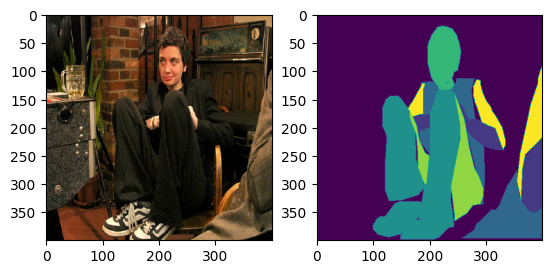

In [11]:
def raster_tensor(im_array,show=True):
    #visualization
    #if type(im_array).__name__ == torch.Tensor.__name__:
    if type(im_array) == torch.Tensor:
        #print('it is torch tensor' , im_array.dtype)
        mn = torch.amin(im_array,dim=(1,2))
        mx = torch.amax(im_array,dim=(1,2))
        nrm = mx - mn
        print('min max norm:',mn,mx, nrm)

        mn = mn[:,None,None]
        mx = mx[:,None,None]
        nrm = nrm[:,None,None]
        im_array = (im_array-mn)/nrm

        mn = torch.amin(im_array,dim=(1,2))
        mx = torch.amax(im_array,dim=(1,2))
        nrm = mx - mn
        print('New min max norm:',mn,mx, nrm)


        #im_array = im_array.contiguous().numpy()
        im_array = im_array.numpy()
        #print(im_array.shape)


        #print(type(im_array),im_array.shape)
        im_array = im_array.transpose(1,2,0)
        #print("transpose ",im_array.shape)

    plt.imshow(im_array)
    if show:
        plt.show()
plt.subplot(1, 2, 1)
raster_tensor(sample['image'],show=False)
plt.subplot(1, 2, 2)
raster_tensor(sample['mask'],show=False)
plt.show()

min max norm: tensor([0]) tensor([2]) tensor([2])
New min max norm: tensor([0.]) tensor([1.]) tensor([1.])
min max norm: tensor([0]) tensor([1]) tensor([1])
New min max norm: tensor([0.]) tensor([1.]) tensor([1.])


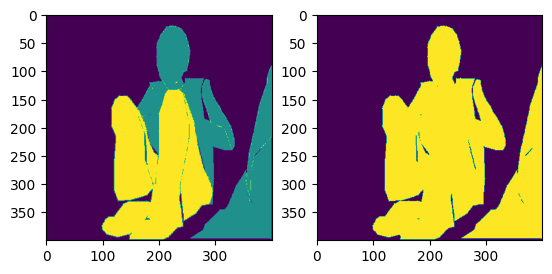

In [12]:
# test body and body's parts
plt.subplot(1, 2, 1)
raster_tensor(parts_mask.cpu(),show=False)
plt.subplot(1, 2, 2)
raster_tensor(body_mask.cpu(),show=False)
plt.show()

## Training

In [13]:
limit = 1600
limit_test = 250
num_workers =os.cpu_count()//2
print("num_workers=",num_workers)
INIT_LR = 0.001
WEIGHT_DECAY=1e-7 # regularizaion. 0 to switch off
NUM_EPOCHS = 10
BATCH_SIZE = 32
PIN_MEMORY = True if DEVICE == "cuda" else False
print(f"DEVICE is",DEVICE)

num_workers= 4
DEVICE is cpu


In [14]:
def set_seed(seed: int = 0):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")
set_seed()

Random seed set as 0


In [15]:
encoder_name="timm-mobilenetv3_small_minimal_100" #"timm-mobilenetv3_small_minimal_100"
encoder_weights="imagenet"
model = smp.create_model("DeepLabV3", encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=3, classes=7  )
#print(model)
params = smp.encoders.get_preprocessing_params(encoder_name)
print(params)
mean = params['mean']
std = params['std']
print(mean, std)
# models.list_models
model = model.to(DEVICE)

{'input_space': 'RGB', 'input_range': [0, 1], 'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}
[0.485, 0.456, 0.406] [0.229, 0.224, 0.225]


In [ ]:
trainDS = PascalDataset(root_dataset,'train',n_limit=limit,transforms=transforms_image,transforms_mask=transforms_mask)
testDS = PascalDataset(root_dataset,'val',n_limit=limit_test,transforms=transforms_image,transforms_mask=transforms_mask)
print(f"train DataSet len=",len(trainDS))
print(f"verification DataSet len=",len(testDS))

Dataset length is limited with 500
train DataSet len= 2826
verification DataSet len= 500


In [ ]:
# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True,
    batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY #)
    ,num_workers=num_workers)
testLoader = DataLoader(testDS, shuffle=False,
    batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY #)
    ,num_workers=num_workers)
print(f'trainLoader = {type(trainLoader)}')

trainLoader = <class 'torch.utils.data.dataloader.DataLoader'>


In [ ]:
import torch.nn as nn
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        IoU = (intersection + smooth)/(union + smooth)

        return 1 - IoU

In [ ]:
# initialize loss function and optimizer
lossFunc = CrossEntropyLoss()
opt = Adam(model.parameters(), lr=INIT_LR)#, weight_decay=WEIGHT_DECAY)
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": [], "mUoI_0":[], "mUoI_1":[],"mUoI_2":[]}
print(f"trainSteps = {trainSteps}, testSteps={testSteps}")

trainSteps = 117, testSteps=20


In [ ]:
def validateBatch(x,y):
    if x.isnan().any():
        #print('x=nan!')
        return False
    if x.isnan().any():
        #print('y=nan!')
        return False
    return True

In [ ]:
#test Dataloader
print(f"trainLoader is {type(trainLoader)}",len(trainLoader))
x = next(iter(trainLoader))
print("x is ",type(x))
img = x['image']; msk = x['mask']
print("img is ",type(img),img.size(),"\nmsk is ",type(msk),msk.size(),msk.dtype)
#print(msk)
#print(msk.max())
#one_msk = msk[0].numpy()
one_msk = msk[0,:,:,:].numpy()
print("one mask shape",one_msk.shape)

img = img.to(DEVICE)
msk = msk.to(DEVICE)

#msk = torch.argmax(msk, dim=1)
msk = msk.squeeze(1) # remove one extra dimention
print("argmax msk is",msk.shape, msk.dtype)

#test model
model.eval()
pred = model(img)
print("pred is",type(pred),pred.shape,pred.dtype)
loss = lossFunc(pred, msk )
print("loss is",type(loss), loss.shape, loss)
print("pred is",type(pred),pred.shape, pred.dtype)
#del pred

trainLoader is <class 'torch.utils.data.dataloader.DataLoader'> 118
x is  <class 'dict'>
img is  <class 'torch.Tensor'> torch.Size([24, 3, 400, 400]) 
msk is  <class 'torch.Tensor'> torch.Size([24, 1, 400, 400]) torch.int64
one mask shape (1, 400, 400)
argmax msk is torch.Size([24, 400, 400]) torch.int64
pred is <class 'torch.Tensor'> torch.Size([24, 7, 400, 400]) torch.float32
loss is <class 'torch.Tensor'> torch.Size([]) tensor(1.9166, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
pred is <class 'torch.Tensor'> torch.Size([24, 7, 400, 400]) torch.float32


In [ ]:
pred0 = torch.argmax(pred, dim=1)
print("pred after argmax",type(pred0),pred0.shape, pred0.dtype)
#pred0 = pred_max.unsqueeze(1)
#print("pred unsqueezed",type(pred0),pred0.shape, pred0.dtype)

pred_1 = mask_2_bodyparts(pred0.cpu()); msk_1 = mask_2_bodyparts(msk.cpu());
pred_2 = mask_2_body(pred_1); msk_2 = mask_2_body(msk_1);
print("Mask bodyparts", msk_1.shape,msk_1.dtype,msk_1.max())
print("Pred bodyparts", pred_1.shape,pred_1.dtype,pred_1.max())
print("Mask body", msk_2.shape,msk_2.dtype,msk_2.max())
print("Pred body", pred_2.shape,pred_2.dtype,pred_2.max())
print("mIoU body parts",miou1(pred_1,msk_1))
print("mIoU body",miou0(pred_2,msk_2))

pred after argmax <class 'torch.Tensor'> torch.Size([24, 400, 400]) torch.int64
Mask bodyparts torch.Size([24, 400, 400]) torch.int64 tensor(2, device='cuda:0')
Pred bodyparts torch.Size([24, 400, 400]) torch.int64 tensor(2, device='cuda:0')
Mask body torch.Size([24, 400, 400]) torch.int64 tensor(1, device='cuda:0')
Pred body torch.Size([24, 400, 400]) torch.int64 tensor(1, device='cuda:0')
mIoU body parts tensor(0.0502, device='cuda:0')
mIoU body tensor(0.1534, device='cuda:0')


In [ ]:
# test UoI loss
UoILoss = IoULoss()
loss = lossFunc(pred, msk )
print("UoI loss is",type(loss), loss.shape, loss)
print("IoU body parts",lossFunc(pred_1.clone().to(torch.float),msk_1.clone().to(torch.float)))
print("IoU body",lossFunc(pred_2.clone().to(torch.float),msk_2.clone().to(torch.float)))

UoI loss is <class 'torch.Tensor'> torch.Size([]) tensor(1.9166, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
IoU body parts tensor(470.2815, device='cuda:0')
IoU body tensor(401.1878, device='cuda:0')


$$
\begin{align}
& IoU^0 - body\\  
& IoU^1 - body\,parts\\  
& IoU^2 - all\,classes
\end{align}
$$

# START TRAIN

In [ ]:
#eps = 0 #1e-10
from tqdm import tqdm
print(f"[INFO] training the network..., train set size is {len(trainLoader)}")
startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
    # set the model in training mode
    model.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalTestLoss = 0
    trainSteps1 = 0
    testSteps1 = 0
    total_mUoI_0 = 0; total_mUoI_1 = 0; total_mUoI_2 = 0
    for (i, tmp) in enumerate(trainLoader):
        x = tmp['image']; y=tmp['mask']
        if len(x) != BATCH_SIZE:
            #print(f'batch size ({len(x)}) != {BATCH_SIZE}, skip')
            continue

        if not validateBatch(x,y):
            print('****************VAL TRAIN************************')
            print('validateBatch False!')
            continue
        trainSteps1 += 1
        # send the input to the device
        (x, y) = (x.to(DEVICE), y.to(DEVICE))
        # perform a forward pass and calculate the training loss
        pred = model(x)
        y = y.squeeze(1)
        loss = lossFunc(pred, y )
        # if i % 30 == 0:
        #     print(f'loss = {loss}, i={i}')

        opt.zero_grad()
        loss.backward()
        opt.step()
        # add the loss to the total training loss so far
        totalTrainLoss += loss
    #print(f'totalTrainLoss={totalTrainLoss},trainSteps={trainSteps}')
    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        # loop over the validation set
        for (i, tmp) in enumerate(testLoader):
            x = tmp['image']; y=tmp['mask']

            if len(x) != BATCH_SIZE:
                #print(f'validate batch size ({len(x)}) != {BATCH_SIZE}, skip')
                continue

            if not validateBatch(x,y):
                print('****************VAL TEST************************')
                print('validateBatch False!')
                continue

            testSteps1 += 1
            # send the input to the device
            (x, y) = (x.to(DEVICE), y.to(DEVICE))
            # make the predictions and calculate the validation loss
            pred = model(x)
            y = y.squeeze(1)
            loss = lossFunc(pred , y )
            totalTestLoss += loss # lossFunc(pred, y)

            #Calc mUoI(s) over a batch
            # miou2 = MeanIoU(num_classes=7, per_class=False, include_background=False, input_format='index')
            # miou1 = MeanIoU(num_classes=3, per_class=False, include_background=False, input_format='index')
            # miou0 = MeanIoU(num_classes=2, per_class=False, include_background=False, input_format='index')
            y_2 = y#.cpu();
            pred_2 = torch.argmax(pred, dim=1) # probabilities to classes
            pred_1 = mask_2_bodyparts(pred_2); y_1 = mask_2_bodyparts(y_2);
            pred_0 = mask_2_body(pred_1); y_0 = mask_2_body(y_1);

            total_mUoI_0 += miou0(pred_0,y_0) #body
            total_mUoI_1 += miou1(pred_1,y_1) #body parts
            total_mUoI_2 += miou2(pred_2,y_2) #all classes

    # calculate the average training and validation loss
    if trainSteps1 != 0:
        avgTrainLoss = totalTrainLoss / trainSteps1
    if testSteps1 != 0:
        avgTestLoss = totalTestLoss / testSteps1
        total_mUoI_0 /= testSteps1
        total_mUoI_1 /= testSteps1
        total_mUoI_2 /= testSteps1
    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
    H["mUoI_0"].append(total_mUoI_0.cpu().detach().numpy())
    H["mUoI_1"].append(total_mUoI_1.cpu().detach().numpy())
    H["mUoI_2"].append(total_mUoI_2.cpu().detach().numpy())
    # print the model training and validation information
    #print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
    #print("Train loss: {:.6f}, Test loss: {:.4f}".format(avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training the network..., train set size is 118


 58%|█████▊    | 7/12 [28:24<20:16, 243.23s/it]

## Final save

In [ ]:
MODEL_PATH = os.path.join(BASE_OUTPUT, "deeplab_mobilenet.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
PLOT_PATH1 = os.path.sep.join([BASE_OUTPUT, "plot1.png"])

# serialize the model to disk
torch.save(model, MODEL_PATH)
print('model saved')

# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)

plt.figure()
plt.plot(H["mUoI_0"], label="mUoI_0")
plt.plot(H["mUoI_1"], label="mUoI_1")
plt.plot(H["mUoI_2"], label="mUoI_2")
plt.title("mUoI metrics")
plt.xlabel("Epoch #")
plt.ylabel("mUoI")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH1)
print("FINISH!")